##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# アテンションを用いたニューラル機械翻訳

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このノートブックでは、スペイン語から英語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。このチュートリアルは、 Sequence to Sequence モデルの知識があることを前提にした上級編のサンプルです。

このノートブックのモデルを訓練すると、_"¿todavia estan en casa?"_  のようなスペイン語の文を入力して、英訳：  _"are you still at home?"_  を得ることができます。

この翻訳品質はおもちゃとしてはそれなりのものですが、生成されたアテンションの図表の方が面白いかもしれません。これは、翻訳時にモデルが入力文のどの部分に注目しているかを表しています。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: このサンプルは P100 GPU 1基で実行した場合に約 10 分かかります。

In [2]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1 MB 5.1 MB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=61dee6b0f870ea5c15d958e33efbdd68a266027bf0ccb9e1f4bc9840f36177fe
  Stored in directory: /home/jovyan/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib


In [3]:
import MeCab

In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## データセットのダウンロードと準備

ここでは、http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには、次のような書式の言語翻訳ペアが含まれています。


```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

さまざまな言語が用意されていますが、ここでは英語ースペイン語のデータセットを使用します。利便性を考えてこのデータセットは Google Cloud 上に用意してありますが、ご自分でダウンロードすることも可能です。データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [5]:
# ファイルのダウンロード
#path_to_zip = tf.keras.utils.get_file(
#    'jpn-eng.zip', origin='file://jpn-eng.zip',
#    extract=True)

path_to_file = "jpn.txt"

In [6]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    # w = unicode_to_ascii(w.lower().strip())
    w = w.lower().strip()

    # 単語とそのあとの句読点の間にスペースを挿入
    # 例：　"he is a boy." => "he is a boy ."
    # 参照：- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, ".", "?", "!", ",") 以外の全ての文字をスペースに置き換え
    # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    # w = '<start> ' + w + ' <end>'
    tagger = MeCab.Tagger("-Owakati -r/etc/mecabrc -d/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")
    w = '<start> ' + tagger.parse(w) + ' <end>'
    return w

In [7]:
en_sentence = u"May I borrow this book?"
ja_sentence = u"私は医者になりたい。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ja_sentence))

<start> may i b orrow this book ? 
 <end>
<start> 私 は 医者 に なり たい 。 
 <end>


In [8]:
# 1. アクセント記号を除去
# 2. 文をクリーニング
# 3. [ENGLISH, SPANISH] の形で単語のペアを返す
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [42]:
en, sp, license = create_dataset(path_to_file, None)
print(len(en),en[-1])
print(len(sp),sp[-1])

77816 <start> i went drinking with one of my boy friend ' s friends , and now he ' s furious at me . was this friend a guy or a girl ? a guy , obviously . why would i go drinking with his female friends ? yeah , you ' re right . his name is tom . he ' s really hot , and i really want to go drinking with him again . 
 <end>
77816 <start> 「 彼氏 の 友達 と 飲み に 行っ たら 彼 に 激怒 さ れ ちゃっ た 」 「 その 『 友達 』 って 、 男 ？ 女 ？ 」 「 男 に 決まっ てる でしょ 。 どうして 、 彼氏 の 女友達 と 飲み に 行か なきゃ いけ ない の ？ 」 「 そりゃそうだ 」 「 彼 ね トム って 言う ん だ けど 、 めっちゃ イケてる の 。 また 行き たい な 」 
 <end>


In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    targ_lang, inp_lang, license = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 実験を速くするためデータセットのサイズを制限（オプション）

100,000 を超える文のデータセットを使って訓練するには長い時間がかかります。訓練を速くするため、データセットのサイズを 30,000 に制限することができます（もちろん、データが少なければ翻訳の品質は低下します）。

In [13]:
# このサイズのデータセットで実験
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [14]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
391 ----> やら
264 ----> なきゃ
387 ----> よかっ
6 ----> た
25 ----> な
4 ----> 。
2 ----> 

3 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> i
1074 ----> shouldn
7 ----> '
15 ----> t
7 ----> '
510 ----> ve
339 ----> done
16 ----> it
4 ----> .
2 ----> 

3 ----> <end>


### tf.data データセットの作成

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

2021-10-09 16:05:30.472252: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 25]), TensorShape([64, 15]))

## エンコーダー・デコーダーモデルの記述

TensorFlow の [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt) に記載されているアテンション付きのエンコーダー・デコーダーモデルを実装します。この例では、最新の API セットを使用します。このノートブックは、上記の seq2seq チュートリアルにある [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) を実装します。下図は、入力の単語ひとつひとつにアテンション機構によって重みが割り当てられ、それを使ってデコーダーが文中の次の単語を予測することを示しています。下記の図と式は [Luong の論文](https://arxiv.org/abs/1508.04025v5) にあるアテンション機構の例です。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

入力がエンコーダーを通過すると、shape が *(batch_size, max_length, hidden_size)* のエンコーダー出力と、shape が *(batch_size, hidden_size)* のエンコーダーの隠れ状態が得られます。

下記に実装されている式を示します。

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

このチュートリアルでは、エンコーダーでは [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) を使用します。簡略化した式を書く前に、表記方法を定めましょう。

* FC = 全結合 (Dense) レイヤー
* EO = エンコーダーの出力
* H = 隠れ状態
* X = デコーダーへの入力


擬似コードは下記のとおりです。

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`　softmax は既定では最後の軸に対して実行されますが、スコアの shape が *(batch_size, max_length, hidden_size)*　であるため、*最初の軸* に適用します。`max_length` は入力の長さです。入力それぞれに重みを割り当てようとしているので、softmax はその軸に適用されなければなりません。
* `context vector = sum(attention weights * EO, axis = 1)`. 上記と同様の理由で axis = 1 に設定しています。
* `embedding output` = デコーダーへの入力 X は Embedding レイヤーを通して渡されます。
* `merged vector = concat(embedding output, context vector)`
* この結合されたベクトルがつぎに GRU に渡されます。

それぞれのステップでのベクトルの shape は、コードのコメントに指定されています。

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 25, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 25, 1)


In [23]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5318)


## オプティマイザと損失関数の定義

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## チェックポイント（オブジェクトベースの保存）

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 訓練

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing - 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # Teacher Forcing を使用
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2021-10-09 16:05:39.988178: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1 Batch 0 Loss 4.2717
Epoch 1 Batch 100 Loss 2.0088
Epoch 1 Batch 200 Loss 1.8553
Epoch 1 Batch 300 Loss 1.7045
Epoch 1 Loss 1.8872
Time taken for 1 epoch 628.7536380290985 sec

Epoch 2 Batch 0 Loss 1.5324
Epoch 2 Batch 100 Loss 1.4043
Epoch 2 Batch 200 Loss 1.3448
Epoch 2 Batch 300 Loss 1.3735
Epoch 2 Loss 1.3687
Time taken for 1 epoch 648.2887587547302 sec

Epoch 3 Batch 0 Loss 1.1195
Epoch 3 Batch 100 Loss 1.0823
Epoch 3 Batch 200 Loss 1.1140
Epoch 3 Batch 300 Loss 1.0607
Epoch 3 Loss 1.1314
Time taken for 1 epoch 641.8006408214569 sec

Epoch 4 Batch 0 Loss 0.9590
Epoch 4 Batch 100 Loss 0.9447
Epoch 4 Batch 200 Loss 0.8771
Epoch 4 Batch 300 Loss 0.8275
Epoch 4 Loss 0.9125
Time taken for 1 epoch 643.5558958053589 sec

Epoch 5 Batch 0 Loss 0.6537
Epoch 5 Batch 100 Loss 0.6677
Epoch 5 Batch 200 Loss 0.6456
Epoch 5 Batch 300 Loss 0.7049
Epoch 5 Loss 0.7123
Time taken for 1 epoch 642.1965169906616 sec

Epoch 6 Batch 0 Loss 0.5615
Epoch 6 Batch 100 Loss 0.4920
Epoch 6 Batch 200 Loss

## 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが *終了トークン* を予測したら、予測を停止する。
* また、*タイムステップごとのアテンションの重み*　を保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

In [29]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [30]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [31]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 最後のチェックポイントを復元しテストする

In [32]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> 私 は 医者 に なり たい 
 <end>
Predicted translation: i want to be a doctor . 
 <end> 


/tmp/ipykernel_37/3491571738.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3491571738.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


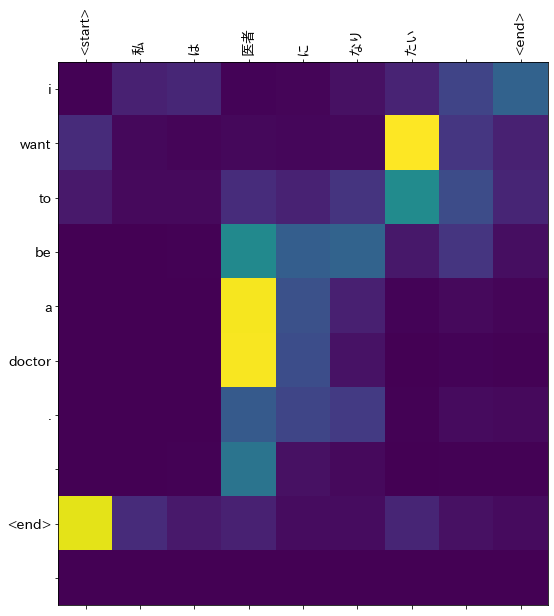

In [33]:
translate(u'私は医者になりたい')

Input: <start> 明日 は 雨 が 降る かも しれ ない 。 
 <end>
Predicted translation: it may rain tomorrow . 
 <end> 


/tmp/ipykernel_37/3491571738.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3491571738.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


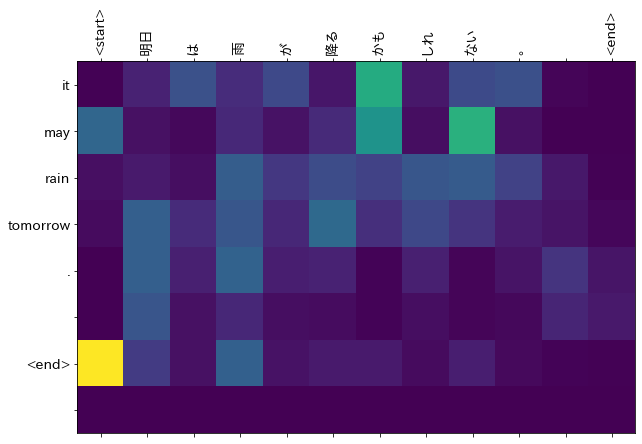

In [34]:
translate(u'明日は雨が降るかもしれない。')

Input: <start> どこ から 来 まし た か ？ 
 <end>
Predicted translation: where did you come from ? 
 <end> 


/tmp/ipykernel_37/3491571738.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_37/3491571738.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


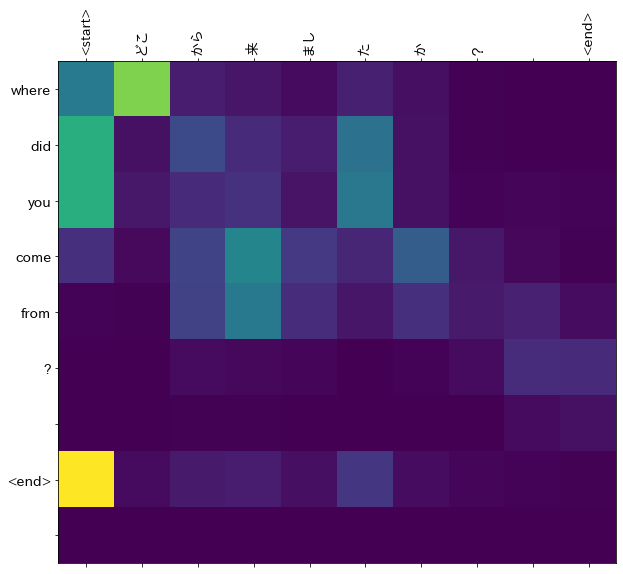

In [35]:
translate(u'どこから来ましたか？')

In [ ]:
# 翻訳あやまりの例
translate(u"")

## 次のステップ

* [異なるデータセットをダウンロード](http://www.manythings.org/anki/)して翻訳の実験を行ってみよう。たとえば英語からドイツ語や、英語からフランス語。
* もっと大きなデータセットで訓練を行ったり、もっと多くのエポックで訓練を行ったりしてみよう。